# Neural Network Jupyter Notebook

The notebook contains all the neccessary code to create a neural network from a training set. 

It is based on the **Torch** framework, and also utilize the **train_test_split** function from the *scikit-learn* library.

The training data is created with the locally imported function **make_training_sets**, and the success of the created neural network is plotted using the locally imported function **create_plots**.

In [1]:
import torch
from sklearn.model_selection import train_test_split
from ann_training_sets import make_training_sets
from ann_testing import create_plots

## Preparation of training sets

The function **prepare_training_sets** splits the input and target data into training, testing and validation sets.

In [2]:
def prepare_training_sets(inputs_tensor, targets_tensor, test_size, val_size, random_state):
    inputs_train, inputs_temp, targets_train, targets_temp = train_test_split(
        inputs_tensor, targets_tensor, test_size=test_size + val_size, random_state=random_state)
    inputs_test, inputs_val, targets_test, targets_val = train_test_split(
        inputs_temp, targets_temp, test_size=val_size/(test_size + val_size), random_state=random_state)
    return inputs_train, inputs_test, inputs_val, targets_train, targets_test, targets_val

## Neural Network Class

The class **ANN** subclasses the **Module** class from PyTorch. It is used to create a Neural Network Object that contains all the connected nodes in a fully-connected Neural Network with all the weights and biases. 

The **__init__** function initializes an Artificial Neural Network according to a specified number of nodes in each layer (*'layers'*) and the activation function (*'activation_func'*).

The **forward** function performs a forward pass through the network with the input tensor *'x'*.

In [3]:
class ANN(torch.nn.Module):
    def __init__(self, layers, activation_func):
        super(ANN, self).__init__()
        self.layers = layers
        self.num_layers = len(layers)
        self.fc_layers = torch.nn.ModuleList()
        self.activation_func = activation_func
        for i in range(self.num_layers - 1):
            self.fc_layers.append(torch.nn.Linear(layers[i], layers[i+1]))
    
    def forward(self, x):
        for i in range(self.num_layers - 2):
            x = self.activation_func(self.fc_layers[i](x))
        x = self.fc_layers[-1](x)
        return x

## Training loop

The function **train_model** will train an initialized *'ann'* object according to a network architecture specified by the optimizer, number of epochs, patience, batch size, and learning rate. It trains the network using the already partitioned *'prepared_training_sets'*, and save the network according to the *'ann_filename'*.

In [4]:
def train_model(ann, optimizer, num_epochs, patience, batch_size, learning_rate,
                prepared_training_sets, ann_filename):
    ann_file_path = '../artificial_neural_networks/neural_networks/' + ann_filename
    inputs_train, inputs_test, inputs_val, targets_train, targets_test, targets_val = prepared_training_sets
    criterion = torch.nn.MSELoss()
    optimizer = optimizer(ann.parameters(), lr=learning_rate)
    best_val_loss = float('inf')
    early_stop_counter = 0
    for epoch in range(num_epochs):
        for i in range(0, len(inputs_train), batch_size):
            input_batch = inputs_train[i:i+batch_size]
            target_batch = targets_train[i:i+batch_size]
            labels = alflow_ann(input_batch)
            loss = criterion(labels, target_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        alflow_ann.eval()
        with torch.no_grad():
            val_labels = alflow_ann(inputs_val)
            val_loss = criterion(val_labels, targets_val)
        print(f'Epoch [{epoch+1}/{num_epochs}], MSE from validation-set: {val_loss.item():.2f}')
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            torch.save(alflow_ann.state_dict(), ann_file_path)
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                break
    end_epoch = epoch + 1
    alflow_ann.eval()
    with torch.no_grad():
        test_labels = alflow_ann(inputs_test)
        test_loss = criterion(test_labels, targets_test)
    residuals = test_labels - targets_test
    std = torch.std(residuals).item()
    print(f"Mean Squared Error (MSE) from test-set: {test_loss.item():.2f}")
    print(f"Standard Deviation (STD) from test-set: {round(std,2)}")
    return residuals

## Training data creation and preparation

With all the neccessary functions defined, it is possible to build the network. Firstly, the training data needs to be defined.

The following example is set for an ALFLOW implementation, and the training data consist of the flow stress calculated from the temperature, strain rate, and strain conditions of a modelled extrution. 

The function **make_training_sets** takes the parameters *'alloy_index'*, *'inputs_filename'*, *'targets_filename'*, *'input_items'* and *'input_ranges'*. It utilizes the Extention Module for the Fortran implemented ALFLOW code to run ALFLOW for every strain rate and temperature combination that a user specifies. The Fortran implementation simulates a strain cycle of 1500  linearly spaced strain values between 0 and a user specified end value.

*'alloy_index'* needs to be an integer between 0 and 8, and it corresponds to an alloy specific input file that ALFLOW requires to run the simulation. The filenames inputs_filename and *'targets_filename'* are the paths where the inputs and targets are saved. They are conventionally saved using the *'.pt'* extention.

In [5]:
alloy_index = [7]   # ['', 'AA1050', 'AA5182' , 'Mg1', 'Mg1~', 'Mg3' , 'Mg3~' , 'Mg05' , 'Mg05~']   
inputs_filename = 'ann_07_06_2024_inputs.pt'  
targets_filename = 'ann_07_06_2024_targets.pt'

*'input_items'* specifies how many different temperature - strain rate - strain conditions that the training data will consist of ( [temp_items, strainrate_items, strain_items] ), and the *'input_ranges'* specify . The function will linearly divide *'temp_items'* elements between the *'temp_range[0]'* and *'temp_range[1]'*, and it will logarithmically divide *'strainrate_items'* elements between the *'strainrate_range[0]'* and *'strainrate_range[1]'*. 

**make_training_sets** will conduct a Fortran simulation for every temperature and strain rate pair over a strain cycle according to 1500 (as required by the Extention Module) linearly spaced strain values between between 0 and *'strain_range[1]'*. Because 1500 strain-stress values for each temperature-strain rate pair might be more than desired, the function will only store *'strain_items'* elements of strain-stress pairs for each simulation.

Each [temperature, strain rate, strain] combination will saved as a tensor, and all these tensors will be stacked to a two-dimensional tensor that is saved under *'inputs_filename'*. The flow stress value for each condition will be saved in a tensor saved under *'targets_filename'*. They are saved in the path '../artificial_neural_networks/ann_inputs_targets/'.

In [6]:
temp_items = 30
temp_range = [273, 773] 
strainrate_items = 30     
strainrate_range = [0.001, 10]
strain_items = 125
strain_range = [0,5]
input_items = [temp_items, strainrate_items, strain_items]
input_ranges = [temp_range, strainrate_range, strain_range]

data_points = make_training_sets(alloy_index, inputs_filename, targets_filename, input_items, input_ranges)
print("Number of training data points: " + str(data_points))

Producing training sets for ranges in temperatures [K]: [273, 773], strain rates [1/s]: [0.001, 10] and strains: [0, 5]
Training data containing: 112500 elements, saved to ann_07_06_2024_inputs.pt and ann_07_06_2024_targets.pt
Number of training data points: 112500


The input tensor and target tensor are retrieved from their saved location using the **torch.load** function. They are divided into the training set, validation set and test set using the **prepare_training_sets** function.

In [7]:
inputs_tensor = torch.load('../artificial_neural_networks/ann_inputs_targets/'+ inputs_filename)
targets_tensor = torch.load('../artificial_neural_networks/ann_inputs_targets/'+ targets_filename)
prepared_training_sets = prepare_training_sets(inputs_tensor, targets_tensor, test_size=0.15, val_size=0.15, random_state=14)

## Neural Network construction

The neural network object can now be constructed from the **ANN** class. 

The *'layers'* parameter consist of the input layer with the required number of nodes (3 for ALFLOW, corresponding to temperature, strain rate and strain), the desired number of nodes in each desired hidden layer, and the output layer with the required number of nodes (1 for ALFLOW, corresponding to the flow stress).

The *'activation_func'* parameter needs to be one of PyTorch's included activation functions, such as *'relu'*, *'sigmoid'*, *'tanh'*, or several others.

In [8]:
layers = [3,60,40,1]
activation_func = torch.relu
alflow_ann = ANN(layers, activation_func)

## Network training

The next task is to train the network using the **train_model** function. This function takes the already untrained neural network object *'ann'* as a parameter, as well as the *'optimizer'*, *'learning_rate'*, *'num_epochs'*, *'patience'* and *'batch_size'*.

The *'optimizer'* needs to be an class from the **torch.optim** module, and an optimizer object will be constructed in the **train_model** function according to the specific *'optimizer'* and *'learning_rate'*. *'num_epochs'* determines the maximum number of epochs for the training process, and the *'patience'* determines how many epochs without validation loss improvement is tolerated. *'batch_size'* determines how many input elements that are forward propogated at the same time.

**train_model** returns *'residuals'*, which is a tensor containing the error between each target from the test set and the models output.

In [9]:
alflow_ann_filename = 'ann_07_06_2024.pth'
optimizer = torch.optim.Adam
learning_rate = 0.001
num_epochs = 500
patience = num_epochs/10
batch_size = 50
residuals = train_model(
    alflow_ann, optimizer, num_epochs, patience, batch_size , learning_rate, prepared_training_sets,alflow_ann_filename)

Epoch 1: MSE = 4566.42
Epoch 2: MSE = 2672.95
Epoch 3: MSE = 675.47
Epoch 4: MSE = 444.87
Epoch 5: MSE = 431.19
Epoch 6: MSE = 423.08
Epoch 7: MSE = 409.39
Epoch 8: MSE = 408.03
Epoch 9: MSE = 388.07
Epoch 10: MSE = 373.96
Epoch 11: MSE = 341.65
Epoch 12: MSE = 332.11
Epoch 13: MSE = 326.14
Epoch 14: MSE = 323.33
Epoch 15: MSE = 319.88
Epoch 16: MSE = 317.48
Epoch 17: MSE = 315.80
Epoch 18: MSE = 313.20
Epoch 19: MSE = 307.10
Epoch 20: MSE = 295.57
Epoch 21: MSE = 272.59
Epoch 22: MSE = 279.45
Epoch 23: MSE = 267.42
Epoch 24: MSE = 193.62
Epoch 25: MSE = 149.79
Epoch 26: MSE = 127.59
Epoch 27: MSE = 116.25
Epoch 28: MSE = 108.54
Epoch 29: MSE = 103.68
Epoch 30: MSE = 95.84
Epoch 31: MSE = 91.26
Epoch 32: MSE = 83.77
Epoch 33: MSE = 79.89
Epoch 34: MSE = 76.48
Epoch 35: MSE = 74.82
Epoch 36: MSE = 72.63
Epoch 37: MSE = 71.24
Epoch 38: MSE = 69.52
Epoch 39: MSE = 68.05
Epoch 40: MSE = 65.64
Epoch 41: MSE = 64.32
Epoch 42: MSE = 63.71
Epoch 43: MSE = 64.33
Epoch 44: MSE = 63.81
Epoch 45: 

Epoch 368: MSE = 3.23
Epoch 369: MSE = 3.30
Epoch 370: MSE = 3.24
Epoch 371: MSE = 3.15
Epoch 372: MSE = 3.14
Epoch 373: MSE = 3.11
Epoch 374: MSE = 3.19
Epoch 375: MSE = 3.40
Epoch 376: MSE = 3.34
Epoch 377: MSE = 3.46
Epoch 378: MSE = 3.34
Epoch 379: MSE = 3.32
Epoch 380: MSE = 3.04
Epoch 381: MSE = 3.33
Epoch 382: MSE = 3.10
Epoch 383: MSE = 3.26
Epoch 384: MSE = 3.27
Epoch 385: MSE = 3.21
Epoch 386: MSE = 3.12
Epoch 387: MSE = 3.08
Epoch 388: MSE = 3.30
Epoch 389: MSE = 3.08
Epoch 390: MSE = 3.01
Epoch 391: MSE = 3.18
Epoch 392: MSE = 3.13
Epoch 393: MSE = 3.42
Epoch 394: MSE = 3.13
Epoch 395: MSE = 3.39
Epoch 396: MSE = 3.24
Epoch 397: MSE = 3.21
Epoch 398: MSE = 3.17
Epoch 399: MSE = 3.25
Epoch 400: MSE = 3.25
Epoch 401: MSE = 3.46
Epoch 402: MSE = 3.48
Epoch 403: MSE = 3.25
Epoch 404: MSE = 3.18
Epoch 405: MSE = 3.20
Epoch 406: MSE = 3.13
Epoch 407: MSE = 3.35
Epoch 408: MSE = 3.60
Epoch 409: MSE = 3.64
Epoch 410: MSE = 3.60
Epoch 411: MSE = 3.38
Epoch 412: MSE = 3.52
Epoch 413:

## Neural Network Plotting

The locally imported function **create_plots** creates a histogram from the test errors tensor *'residuals'*, as well as a comparison plot of ALFLOW against the ANN for three different [temperature, strain rate, strain] conditions

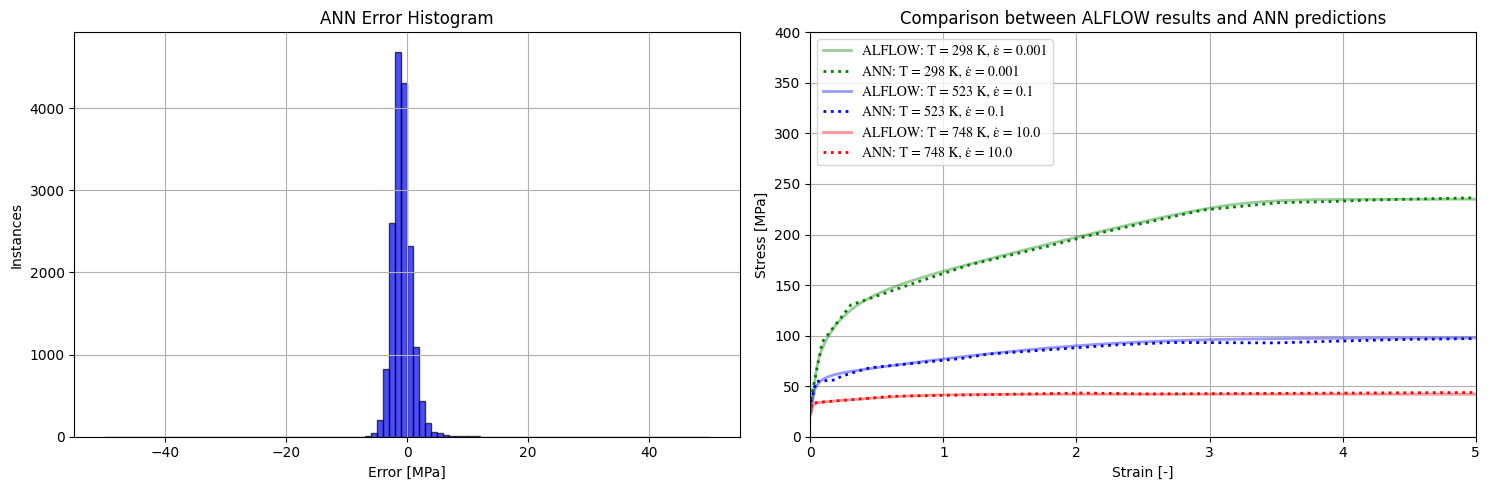

In [10]:
create_plots(temp_range, strainrate_range, strain_range, alloy_index, alflow_ann_filename, alflow_ann, residuals)